In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  5 14:35:35 2025
Compare roi-averaged signal changes between Accept and Decline SH
@author: yuhui
"""
import os
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import glob
from statsmodels.stats.multitest import multipletests

In [ ]:
# Define data directory
data_dir = '/media/yuhui/LCT/'
os.chdir(data_dir)

# Define stats prefix and coefficient list
stats_prefix = 'stats4AR.blur1.rbold.'
coef_list = ['ProbMM valueLH A', 'ProbMM valueLH R', 'ProbMM valueSH A', 'ProbMM valueSH R']

roi_list = [
    'lc', 'snvta', 'pos_pfc', 'NAc', 'caudate',
    'gray_bridge', 'putamen'
]

In [3]:
roi_num = len(roi_list)
coef_num = len(coef_list)

######################################################
# Initialize results storage
df_results = []
all_roi_data = []
all_roi_sem = []
all_t_stats = []
all_p_vals = []

all_roi_high_subject = []
all_roi_low_subject = []

In [ ]:
for roi in roi_list:
    bold_mean_file = f"{stats_prefix}{roi}.1D"
    
    # Define the search pattern (equivalent to "2*LCT*/bold.sft/roiProfile/")
    search_pattern = f"{data_dir}/2*/bold.sft/roiProfile/{bold_mean_file}"

    # Find all matching files
    bold_subj_list = sorted(glob.glob(search_pattern))
    
    subj_num = len(bold_subj_list)

    if subj_num > 0:
        roi_mean_all = np.zeros((coef_num, subj_num))
        
        for subj_idx, subj_file in enumerate(bold_subj_list):
            roi_mean_all[:, subj_idx] = np.loadtxt(subj_file)

        A_indices = np.where(np.isin(coef_list, ['ProbMM valueSH A']))[0]
        R_indices = np.where(np.isin(coef_list, ['ProbMM valueSH R']))[0]

        # Compute mean across selected indices
        roi_mean_all = np.vstack([
            np.mean(roi_mean_all[A_indices, :], axis=0),
            np.mean(roi_mean_all[R_indices, :], axis=0)
        ])
        coef_list1 = ['ProbMM valueSH A', 'ProbMM valueSH R']

        # Store subject-level data for later comparisons
        all_roi_high_subject.append(roi_mean_all[1, :])
        all_roi_low_subject.append(roi_mean_all[0, :])

        roi_mean = np.mean(roi_mean_all, axis=1)
        roi_sem = np.std(roi_mean_all, axis=1) / np.sqrt(subj_num)

        # Store ROI data for combined plot
        all_roi_data.append(roi_mean)
        all_roi_sem.append(roi_sem)
        
        # Perform paired t-tests for last two coefficients
        data1, data2 = roi_mean_all[-2, :], roi_mean_all[-1, :]
        t_stat, p_val = stats.ttest_rel(data1, data2)
        cohen_d = t_stat / np.sqrt(subj_num)
        df = subj_num - 1
        
        df_results.append([roi, t_stat, p_val, cohen_d, df])
        all_t_stats.append(t_stat)
        all_p_vals.append(p_val)

# Convert results to DataFrame
df_results = pd.DataFrame(df_results, columns=['ROI', 't_value', 'p_value', 'Cohen_d', 'df'])

# Apply FDR correction (Benjamini-Hochberg)
p_vals_array = np.array(all_p_vals)  # Convert p-values to array
_, p_vals_corrected, _, _ = multipletests(p_vals_array, alpha=0.05, method='fdr_bh')

df_results["p_value_corrected"] = p_vals_corrected
print(df_results)

# Convert all ROI data to a NumPy array for plotting
all_roi_data = np.array(all_roi_data)
all_roi_sem = np.array(all_roi_sem)
all_t_stats = np.array(all_t_stats)
all_p_vals = np.array(all_p_vals)

           ROI   t_value   p_value   Cohen_d  df  p_value_corrected
0           lc  3.445529  0.002710  0.770444  19           0.003794
1        snvta  0.548740  0.589575  0.122702  19           0.589575
2      pos_pfc  3.097634  0.005926  0.692652  19           0.006914
3          NAc  5.158324  0.000056  1.153436  19           0.000391
4      caudate  3.888327  0.000989  0.869456  19           0.003461
5  gray_bridge  3.479665  0.002508  0.778077  19           0.003794
6      putamen  3.507135  0.002357  0.784219  19           0.003794


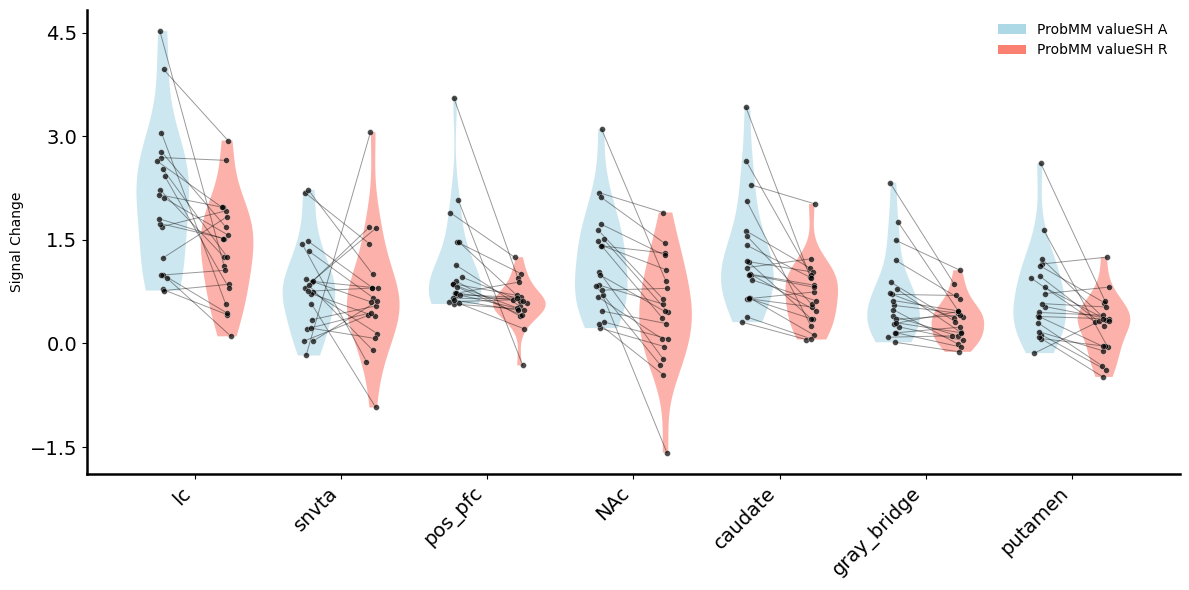

In [ ]:
# %% Violin plot for All ROIs (replaces the bar plot)
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(roi_list))
offset = 0.22          # half-distance between the two violins per ROI
vwidth = 0.36          # violin width
low_color  = 'lightblue'
high_color = 'salmon'

# Keep your y-limits logic (based on mean±SEM) for consistent scaling
max_y = np.max(all_roi_data + all_roi_sem)
min_y = np.min(all_roi_data - all_roi_sem)

for i in range(len(roi_list)):
    low  = np.asarray(all_roi_low_subject[i],  float)
    high = np.asarray(all_roi_high_subject[i], float)

    # violins (low, high) at left/right of the ROI center
    parts = ax.violinplot([low, high],
                          positions=[x[i] - offset, x[i] + offset],
                          widths=vwidth,
                          showmeans=False, showmedians=False, showextrema=False)
    parts['bodies'][0].set_facecolor(low_color); parts['bodies'][0].set_alpha(0.6); parts['bodies'][0].set_edgecolor('none')
    parts['bodies'][1].set_facecolor(high_color); parts['bodies'][1].set_alpha(0.6); parts['bodies'][1].set_edgecolor('none')

    # --- Paired slope lines + points (use SAME jitter for Low & High) ---
    rng = np.random.default_rng(7 + i)

    low_v  = np.asarray(all_roi_low_subject[i],  float)
    high_v = np.asarray(all_roi_high_subject[i], float)

    # pairwise drop NaNs so each line connects valid Low–High for the same subject
    mask   = np.isfinite(low_v) & np.isfinite(high_v)
    low_p  = low_v[mask]
    high_p = high_v[mask]

    # same horizontal jitter for both ends so the line hits both dots
    base_jit = rng.normal(0, 0.02, size=low_p.size)
    x_low  = x[i] - offset + base_jit
    x_high = x[i] + offset + base_jit

    # draw lines first (under the dots)
    for xl, xh, yl, yh in zip(x_low, x_high, low_p, high_p):
        ax.plot([xl, xh], [yl, yh], color='k', alpha=0.4, lw=0.7, zorder=4)

    # dots (use the same jitter)
    ax.scatter(x_low,  low_p,  s=18, alpha=0.7, color='k',
            linewidth=0.3, edgecolor='white', zorder=5)
    ax.scatter(x_high, high_p, s=18, alpha=0.7, color='k',
            linewidth=0.3, edgecolor='white', zorder=5)


# axes, ticks, labels, legend
ax.set_xticks(x)
ax.set_xticklabels(roi_list, rotation=45, ha='right')
ax.set_ylabel("Signal Change")
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(5))
from matplotlib.patches import Patch
ax.legend(handles=[Patch(facecolor=low_color,  label=coef_list1[0]),
                   Patch(facecolor=high_color, label=coef_list1[1])],
          frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.8)
ax.spines['bottom'].set_linewidth(1.8)

plt.tight_layout()
plt.savefig("output/roi_AR_violin.png", dpi=300, bbox_inches='tight')